# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

---
## 2. Load data

In [11]:
client_df = pd.read_csv('../Data/clean_data_after_eda.csv')
client_df["date_activ"] = pd.to_datetime(client_df["date_activ"], format='%Y-%m-%d')
client_df["date_end"] = pd.to_datetime(client_df["date_end"], format='%Y-%m-%d')
client_df["date_modif_prod"] = pd.to_datetime(client_df["date_modif_prod"], format='%Y-%m-%d')
client_df["date_renewal"] = pd.to_datetime(client_df["date_renewal"], format='%Y-%m-%d')

In [12]:
client_df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000131,4.100838e-05,0.000908,2.086294,99.530517,44.235794,2.086425,9.953056e+01,44.236702,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000003,1.217891e-03,0.000000,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000,0


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [13]:
price_df = pd.read_csv('../Data/price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


Now it is time to get creative and to conduct some of your own feature engineering! Have fun with it, explore different ideas and try to create as many as you can!

In [28]:
# =============================================================================
# 2. DATE-BASED FEATURES
# =============================================================================
print("\n--- Engineering Date-based Features ---")

# Calculate customer tenure in months
# We'll use the 'date_end' as the reference for when the tenure is measured
client_df['tenure_months'] = client_df['date_end'].dt.to_period('M').astype(int) - client_df['date_activ'].dt.to_period('M').astype(int)
client_df['tenure_months'] = client_df['tenure_months'].astype(int)

print("Feature 'tenure_months' created.")
print(client_df[['id', 'tenure_months']].head())


--- Engineering Date-based Features ---
Feature 'tenure_months' created.
                                 id  tenure_months
0  24011ae4ebbe3035111d65fa7c15bc57             36
1  d29c2c54acc38ff3c0614d0a653813dd             84
2  764c75f661154dac3a6c254cd082ea7d             72
3  bba03439a292a1e166f80264c16191cb             72
4  149d57cf92fc41cf94415803a877cb4b             74


In [37]:
# =============================================================================
# 3. PRICE-BASED FEATURES
# =============================================================================
print("\n--- Engineering Price-based Features ---")
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()


--- Engineering Price-based Features ---


,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [38]:
# --- 3.2 Price Volatility, Averages, and Max Price Difference Across Periods ---
price_df['diff_peak_offpeak_var'] = price_df['price_peak_var'] - price_df['price_off_peak_var']
price_agg_feats = price_df.groupby('id').agg(
    avg_price_off_peak_var=('price_off_peak_var', 'mean'),
    price_volatility_var=('price_off_peak_var', 'std'),
    max_price_off_peak_var=('price_off_peak_var', 'max'),
    avg_diff_peak_offpeak_var=('diff_peak_offpeak_var', 'mean'), # Avg difference between peak and off-peak
    max_diff_peak_offpeak_var=('diff_peak_offpeak_var', 'max')   # Max difference between peak and off-peak
).reset_index()
print("Features for price volatility, averages, and cross-period differences created.")


Features for price volatility, averages, and cross-period differences created.


In [30]:
# --- 3.2 Price Volatility and Averages ---
# These are useful for general predictive modeling.
price_agg_feats = price_df.groupby('id').agg(
    avg_price_off_peak_var=('price_off_peak_var', 'mean'),
    std_price_off_peak_var=('price_off_peak_var', 'std'), # Volatility
    max_price_off_peak_var=('price_off_peak_var', 'max')
).reset_index()
price_agg_feats = price_agg_feats.rename(columns={'std_price_off_peak_var': 'price_volatility_var'})
print("Features for price volatility and averages created.")


Features for price volatility and averages created.


In [39]:
# --- 3.3 "Price Hike" Treatment Variable (for Causal Inference) ---
price_df_sorted = price_df.sort_values(['id', 'price_date'])
price_df_sorted['prev_price_var'] = price_df_sorted.groupby('id')['price_off_peak_var'].shift(1)
price_df_sorted['price_pct_change_var'] = ((price_df_sorted['price_off_peak_var'] - price_df_sorted['prev_price_var']) / price_df_sorted['prev_price_var']) * 100
price_hike_feats = price_df_sorted.groupby('id').agg(
    max_monthly_increase_pct=('price_pct_change_var', 'max')
).reset_index()
hike_threshold = 20
price_hike_feats['treatment_price_hike'] = (price_hike_feats['max_monthly_increase_pct'] > hike_threshold).astype(int)
print(f"Causal treatment variable 'treatment_price_hike' created with a threshold of {hike_threshold}%.")


Causal treatment variable 'treatment_price_hike' created with a threshold of 20%.



--- Transforming Data for Modeling ---
Boolean column 'has_gas' converted to binary.
Dummy variables created for 'channel_sales'.


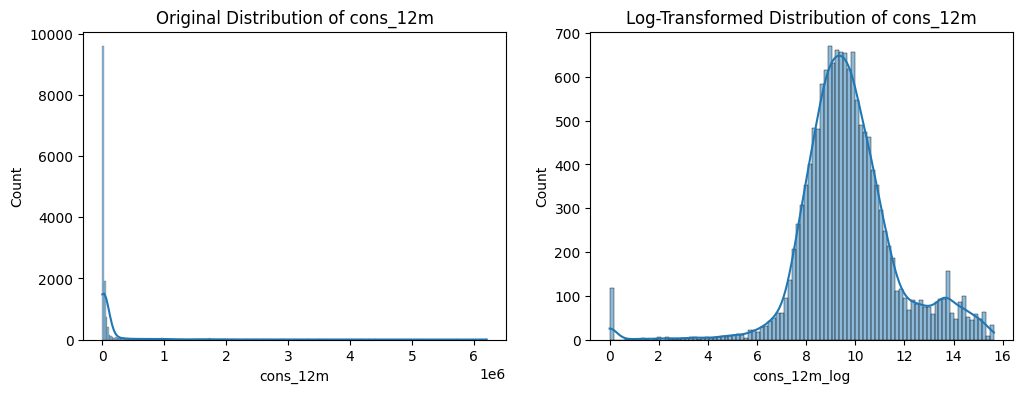

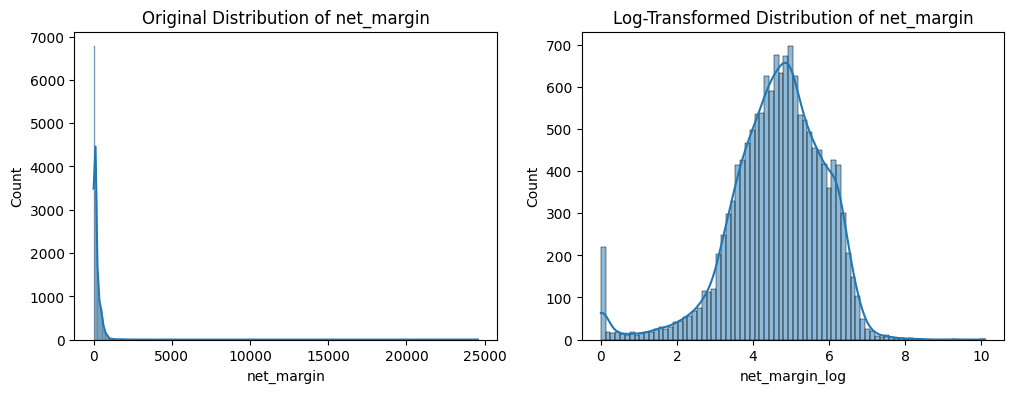

Log transformation applied to skewed columns.


In [48]:
# =============================================================================
# 4. DATA TRANSFORMATION (NEW SECTION)
# =============================================================================
print("\n--- Transforming Data for Modeling ---")

# --- 4.1 Convert Boolean to Binary ---
client_df['has_gas_binary'] = client_df['has_gas'].map({'t': 1, 'f': 0})
print("Boolean column 'has_gas' converted to binary.")

# --- 4.2 Create Dummy Variables for Categorical Data ---
client_df['channel_sales'] = client_df['channel_sales'].fillna('Unknown')
channel_dummies = pd.get_dummies(client_df['channel_sales'], prefix='channel')
client_df = pd.concat([client_df, channel_dummies], axis=1)
print("Dummy variables created for 'channel_sales'.")

# --- 4.3 Log Transform Skewed Numerical Columns ---
skewed_cols = ['cons_12m', 'net_margin']
for col in skewed_cols:
    if col in client_df.columns:
        # Adding 1 to avoid log(0) issues
        client_df[f'{col}_log'] = np.log1p(client_df[col])

        # Visualize before and after
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        sns.histplot(client_df[col], kde=True, ax=ax1)
        ax1.set_title(f'Original Distribution of {col}')
        sns.histplot(client_df[f'{col}_log'], kde=True, ax=ax2)
        ax2.set_title(f'Log-Transformed Distribution of {col}')
        plt.show()
    else:
        print(f"Warning: Column '{col}' not found in dataframe. Skipping log transformation.")

print("Log transformation applied to skewed columns.")


In [51]:
# =============================================================================
# 5. COMBINE ALL FEATURES
# =============================================================================
print("\n--- Combining all new features into a final dataframe ---")
base_df = client_df.drop(columns=['date_activ', 'date_end', 'has_gas', 'channel_sales', 'cons_12m', 'net_margin'])
df_final = base_df.merge(diff, on='id', how='left')
df_final = df_final.merge(price_agg_feats, on='id', how='left')
df_final = df_final.merge(price_hike_feats, on='id', how='left')
df_final.fillna(0, inplace=True)
print("All features merged successfully.")
print("Final dataframe shape:", df_final.shape)


--- Combining all new features into a final dataframe ---
All features merged successfully.
Final dataframe shape: (14606, 59)


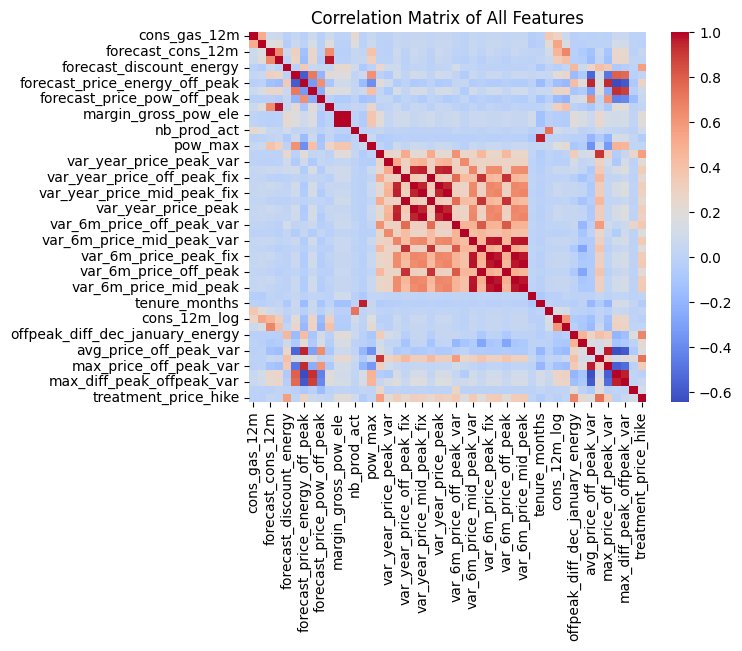

Correlation matrix generated. High correlation between features can be identified and addressed before modeling.


In [53]:
# =============================================================================
# 6. FINAL CORRELATION ANALYSIS (NEW SECTION)
# =============================================================================
numeric_cols = df_final.select_dtypes(include=np.number)
correlation_matrix = numeric_cols.corr()

sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix of All Features')
plt.show()

print("Correlation matrix generated. High correlation between features can be identified and addressed before modeling.")
